In [5]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams, gridspec
from pandas.api.types import CategoricalDtype
import shap
import xgboost

import sklearn
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import tree

In [6]:
import gc
gc.collect()

83

In [7]:
os.chdir("/Users/kelsey.huntzberry/Documents/Classes/Machine_Learning_Class/Data")
print(os.getcwd())

/Users/kelsey.huntzberry/Documents/Classes/Machine_Learning_Class/Data


In [16]:
# Read in Treatment Episode Data Set data
teds18 = pd.read_csv('tedsa_puf_2018.csv')

In [17]:
# Subset the data to just the 0/1 drug flag variables
flags = teds18.filter(regex='FLG$', axis = 1)

In [18]:
# Sum the flag variables to calculate the number of drugs recorded for each individual
NUMSUBS = flags.sum(axis=1)

In [19]:
# Concatenate flag variables back into the 2015-17 data
teds_wflgs = pd.concat([teds18, NUMSUBS], axis = 1)
teds_wflgs.rename(columns={0:'NUMSUBS'}, inplace = True)

In [20]:
# Remove rows where the first substance was "None"
teds_sm_temp = teds_wflgs[teds_wflgs.SUB1 != 1]
# Remove rows where number of prior treatments is NA (target variable)
teds_sm1 = teds_sm_temp[teds_sm_temp.NOPRIOR != -9]

In [21]:
# Select subset of columns
teds_sm = teds_sm1.loc[:,['CASEID','ADMYR','AGE','GENDER','RACE','ETHNIC','EDUC','EMPLOY','VET','LIVARAG',\
                          'STFIPS','CBSA2010','DIVISION','REGION','SERVICES','PSOURCE','NOPRIOR','ARRESTS','ROUTE1','FRSTUSE1','FREQ1', \
                          'ROUTE2','FRSTUSE2', 'FREQ2','ROUTE3','FRSTUSE3','FREQ3','NUMSUBS','METHUSE','ALCFLG','PSYPROB', \
                          'COKEFLG','MARFLG','HERFLG','METHFLG','OPSYNFLG','PCPFLG','HALLFLG','MTHAMFLG','AMPHFLG','STIMFLG', \
                          'BENZFLG','TRNQFLG','BARBFLG','SEDHPFLG','INHFLG','OTCFLG','OTHERFLG']]

In [22]:
# Recode age group variable
def age_groups(series):
    if series == 1:
        return '12_14_years'
    elif series == 2:
        return '15_17_years'
    elif series == 3:
        return '18_20_years'
    elif series == 4:
        return '21_24_years'
    elif series == 5:
        return '25_29_years'
    elif series == 6:
        return '30_34_years'
    elif series == 7:
        return '35_39_years'
    elif series == 8:
        return '40_44_years'
    elif series == 9:
        return '45_49_years'
    elif series == 10:
        return '50_54_years'
    elif series == 11:
        return '55_64_years'
    elif series == 12:
        return '65_plus_years'
    
teds_sm1.loc[:, 'age_group'] = teds_sm1.AGE.apply(age_groups)

# Change variable to an ordered factor
teds_sm1.loc[:, 'age_group'] = pd.Categorical(teds_sm1['age_group'], categories = ['12_14_years', '15_17_years', '18_20_years',
                                                                                   '21_24_years', '25_29_years', '30_34_years',
                                                                                   '35_39_years', '40_44_years', '45_49_years',
                                                                                   '50_54_years', '55_64_years', '65_plus_years'], ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'age_group'], sort = True)
teds_sm1.loc[:, 'age_group'] = labels


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
# Recode gender variable
def gen_rc(series):
    if series == 1:
        return 0
    elif series == 2:
        return 1
    
teds_sm1.loc[:, 'gender'] = teds_sm1.GENDER.apply(gen_rc)

In [24]:
# Recode methadone variable
def methadone_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'methadone_use'] = teds_sm1.METHUSE.apply(methadone_rc)

In [25]:
def educ_rc(series):
    if series == 1:
        return 'No_Schooling'
    elif series == 2:
        return 'Grades_9_to_11'
    elif series == 3:
        return 'Grades_12_or_GED'
    elif series == 4:
        return 'College_1_to_3_years'
    elif series == 5:
        return 'College_4_or_more_years'

teds_sm1.loc[:, 'educ'] = teds_sm1.EDUC.apply(educ_rc)

# Change variable to an ordered factor
teds_sm1.loc[:, 'educ'] = pd.Categorical(teds_sm1['educ'], categories = ['No_Schooling', 'Grades_9_to_11', 'Grades_12_or_GED',
                                                                         'College_1_to_3_years', 'College_4_or_more_years'], ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'educ'], sort = True)
teds_sm1.loc[:, 'educ'] = labels

In [26]:
# Record race variable
def race_rc(series):
    if series == 1:
        return 'Alaska_Native'
    elif series == 2:
        return 'American_Indian'
    elif series == 3 or series == 9:
        return 'Hawaiian_Pacific_Islander'
    elif series == 4:
        return 'Black'
    elif series == 5:
        return 'White'
    elif series == 6:
        return 'Asian'
    elif series == 7:
        return 'Other_race'
    elif series == 8:
        return 'Two_or_more_races'
    
teds_sm1.loc[:, 'race'] = teds_sm1.RACE.apply(race_rc)

In [27]:
# Recode ethnicity variable
def ethnic_rc(series):
    if (series >= 1 or series <= 3) or series == 5:
        return 'Hispanic'
    elif series == 4:
        return 'Not_Hispanic'
    
teds_sm1.loc[:, 'ethnic'] = teds_sm1.ETHNIC.apply(ethnic_rc)

In [28]:
# Recode service setting variable
def servseta_rc(series):
    if series == 1 or series == 2:
        return 'Detox'
    elif series >= 3 and series <= 5:
        return 'Rehab_Residential'
    elif series >= 6 and series <= 8:
        return 'Ambulatory'

teds_sm1.loc[:, 'services'] = teds_sm1.SERVICES.apply(servseta_rc)

In [29]:
# Recode marital status variable
def marstat_rc(series):
    if series == 1:
        return 'Never_Married'
    elif series == 2:
        return 'Married'
    elif series == 3:
        return 'Separated'
    elif series == 4:
        return 'Divorced_or_Widowed'

teds_sm1.loc[:, 'marstat'] = teds_sm1.MARSTAT.apply(marstat_rc)

In [30]:
# Recode employment status variable
def employ_rc(series):
    if series == 1:
        return 'Full_time'
    elif series == 2:
        return 'Part_time'
    elif series == 3:
        return 'Unemployed'
    elif series == 4:
        return 'Not_in_labor_force'
    
teds_sm1.loc[:, 'employ'] = teds_sm1.EMPLOY.apply(employ_rc)

In [31]:
# Recode veteran variable
def vet_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'vet'] = teds_sm1.VET.apply(vet_rc)

In [32]:
# Recode living arrangement variable
def livarag_rc(series):
    if series == 1:
        return 'Homeless'
    elif series == 2:
        return 'Dependent_Living'
    elif series == 3:
        return 'Independent_Living'

teds_sm1.loc[:, 'livarag'] = teds_sm1.LIVARAG.apply(livarag_rc)

In [33]:
# Recode arrests variable
def arrests_rc(series):
    if series == 0:
        return 'None'
    elif series == 1:
        return 'Once'
    elif series == 2:
        return 'Two_or_more_times'
    
teds_sm1.loc[:, 'arrests'] = teds_sm1.ARRESTS.apply(arrests_rc)

# Change variable to an ordered factor variable
teds_sm1.loc[:, 'arrests'] = pd.Categorical(teds_sm1['arrests'], categories = ['None', 'Once',
                                                                              '2 or more times'],
                                           ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'arrests'], sort = True)
teds_sm1.loc[:, 'arrests'] = labels

In [34]:
# Recode division variable
def division_rc(series):
    if series == 0:
        return 'US_Territories'
    elif series == 1:
        return 'New_England'
    elif series == 2:
        return 'Mid_Atlantic'
    elif series == 3:
        return 'East_North_Central'
    elif series == 4:
        return 'West_North_Central'
    elif series == 5:
        return 'South_Atlantic'
    elif series == 6:
        return 'East_South_Central'
    elif series == 7:
        return 'West_South_Central'
    elif series == 8:
        return 'Mountain'
    elif series == 9:
        return 'Pacific'
    
teds_sm1.loc[:, 'division'] = teds_sm1.DIVISION.apply(division_rc)

In [35]:
# Recode referral source variable
def psource_rc(series):
    if series == 1:
        return 'Self_referral'
    elif series == 2:
        return 'Alcohol_Drug_Care_Professional'
    elif series == 3:
        return 'Other_Health_Care_Professional'
    elif series == 4:
        return 'School_Referral'
    elif series == 5:
        return 'Employer_Referral'
    elif series == 6:
        return 'Community_Referral'
    elif series == 7:
        return 'Court_Referral'
    
teds_sm1.loc[:, 'psource'] = teds_sm1.PSOURCE.apply(psource_rc)

In [36]:
# Recode number of prior treatment encounters
def noprior_rc(series):
    if series == 0:
        return 0
    elif series >= 1:
        return 1
    
teds_sm1.loc[:, 'noprior'] = teds_sm1.NOPRIOR.apply(noprior_rc)

In [37]:
# Recode mental illness variable
def psyprob_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'psyprob'] = teds_sm1.PSYPROB.apply(psyprob_rc)

In [38]:
def first_age_recode(column1, column2, column3):
    if column1 == 1 or column2 == 1 or column3 == 1:
        return '11_years_and_under'
    elif column1 == 2 or column2 == 2 or column3 == 2:
        return '12_14_years'
    elif column1 == 3 or column2 == 3 or column3 == 3:
        return '15_17_years'
    elif column1 == 4 or column2 == 4 or column3 == 4:
        return '18_20_years'
    elif column1 == 5 or column2 == 5 or column3 == 5:
        return '21_24_years'
    elif column1 == 6 or column2 == 6 or column3 == 6:
        return '25_29_years'
    elif column1 == 7 or column2 == 7 or column3 == 7:
        return '30_years_older'

teds_sm1.loc[:, 'frstuse'] = teds_sm1.apply(lambda x: first_age_recode(x.FRSTUSE1, x.FRSTUSE2, x.FRSTUSE3), axis=1)

# Change first use into an ordered factor
teds_sm1.loc[:, 'frstuse'] = pd.Categorical(teds_sm1['frstuse'], categories = ['11_years_and_under', '12_14_years', '15_17_years',
                                                                               '18_20_years', '21_24_years',
                                                                               '25_29_years', '30_years_older'], ordered = True)
# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'frstuse'], sort = True)
teds_sm1.loc[:, 'frstuse'] = labels

In [39]:
def freq_recode(column1, column2, column3):
    if (column1 == 1 and column2 == 1 and column3 == 1):
        return 'No_Use_Past_Month'
    elif (column1 == 3 or column2 == 3 or column3 == 3):
        return 'Daily_Use'
    elif (column1 == 2 or column2 == 2 or column3 == 2):
        return 'Some_Use'
    elif (column1 == 1 or column2 == 1 or column3 == 1):
        return 'No_Use_Past_Month'

teds_sm1.loc[:, 'freq_use'] = teds_sm1.apply(lambda x: freq_recode(x.FREQ1, x.FREQ2, x.FREQ3), axis=1)

# Change first use into an ordered factor
teds_sm1.loc[:, 'freq_use'] = pd.Categorical(teds_sm1['freq_use'], categories = ['No_Use_Past_Month', 'Daily_Use', 'Some_Use'], ordered = True)
# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'freq_use'], sort = True)
teds_sm1.loc[:, 'freq_use'] = labels

In [40]:
def oral_recode(column1, column2, column3):
    if (column1 == 1 and column1 != None) or (column2 == 1 and column2 != None) or (column3 == 1 and column3 != None):
        return 1
    elif (column1 > 1 and column1 != None) or (column2 > 1 and column2 != None) or (column3 > 1 and column3 != None):
        return 0

teds_sm1.loc[:, 'oral_drug_use'] = teds_sm1.apply(lambda x: oral_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

def smoking_recode(column1, column2, column3):
    if (column1 == 2 and column1 != None) or (column2 == 2 and column2 != None) or (column3 == 2 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0

teds_sm1.loc[:, 'smoking_drug_use'] = teds_sm1.apply(lambda x: smoking_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

def inhalation_recode(column1, column2, column3):
    if (column1 == 3 and column1 != None) or (column2 == 3 and column2 != None) or (column3 == 3 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0
    
teds_sm1.loc[:, 'inhale_drug_use'] = teds_sm1.apply(lambda x: inhalation_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)
    
def injection_recode(column1, column2, column3):
    if (column1 == 4 and column1 != None) or (column2 == 4 and column2 != None) or (column3 == 4 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0
    
teds_sm1.loc[:, 'injection_drug_use'] = teds_sm1.apply(lambda x: injection_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

In [41]:
# Subset to fewer variables, mostly dropping those with many missing values
teds_clean = teds_sm1.drop(['ADMYR', 'CASEID', 'STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES',
                            'DETCRIM', 'NOPRIOR', 'PSOURCE', 'ARRESTS', 'EMPLOY', 'METHUSE',
                            'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'DSMCRIT',
                            'AGE', 'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3',
                            'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1', 'FREQ2', 'FREQ3', 'FRSTUSE1',
                            'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP', 
                            'IDU','REGION','METHFLG'], axis = 1)

In [174]:
# teds_clean[teds_clean['educ'] == -1] = None
# teds_clean[teds_clean['frstuse'] == -1] = None
# teds_clean[teds_clean['freq_use'] == -1] = None
# teds_clean[teds_clean['arrests'] == -1] = None

In [42]:
# Create dummy variables for unordered categorical variables
teds2018 = pd.get_dummies(teds_clean, columns=['race','psource','division','ethnic','services','marstat','employ',
                                                'livarag'])

In [43]:
# Subset data for easy analysis
teds2018 = teds2018.sample(n = 200000, random_state=16)

In [8]:
#teds2018.to_csv("teds_data_small.csv",index=False)
teds2018 = pd.read_csv("teds_data_small.csv")

In [9]:
# Dropping division since we have region already
teds2018 = teds2018.drop(columns=['DIVISION'])

In [10]:
# Drop response variable and year since only 2017 will be used in final modeling
data = teds2018.drop(columns = ['noprior'])
# Create data frame with just the response variable
response = teds2018.loc[:,['noprior']]

In [11]:
# Change response and predictor data frames to numpy arrays
data_imp_np = np.array(data)
response_np = np.array(response)

In [12]:
# Create holdout data set and keep remaining 80% in one data frame
# Used stratefied random sampling because there was class imbalance
sss = StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state=0)

sss.get_n_splits(data_imp_np, response_np)

for train_index, test_index in sss.split(data_imp_np, response_np):
    x_train_temp, x_test = data_imp_np[train_index], data_imp_np[test_index]
    y_train_temp, y_test = response_np[train_index], response_np[test_index]

# Split the remaining data into a training and validation data set (50% and 30% respectively)
sss_valid = StratifiedShuffleSplit(n_splits = 2, test_size = 0.3, random_state = 10)  
    
for train_index, test_index in sss_valid.split(x_train_temp, y_train_temp):
    x_train, x_validation = x_train_temp[train_index], x_train_temp[test_index]
    y_train, y_validation = y_train_temp[train_index], y_train_temp[test_index]

    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [13]:
x_train = np.where(x_train == -1, np.nan, x_train)
x_validation = np.where(x_validation == -1, np.nan, x_validation)
x_test = np.where(x_test == -1, np.nan, x_test)

In [14]:
# Impute missing data witn mode
my_imputer = SimpleImputer(strategy = 'most_frequent')
imputer = my_imputer.fit(x_train)
x_train = imputer.transform(x_train)
x_validation = imputer.transform(x_validation)
x_test = imputer.transform(x_test)
data.columns = data.columns
columns = data.columns

In [15]:
# Create user-defined function to create formatted confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    print ()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=20, fontsize = 14)
    plt.yticks(tick_marks, classes, fontsize = 14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 14)
    plt.xlabel('Predicted label', fontsize = 14)


In [16]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model = GradientBoostingClassifier(random_state=75)
gbt_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model.predict_proba(x_validation)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.71      0.71     48000


Normalized confusion matrix



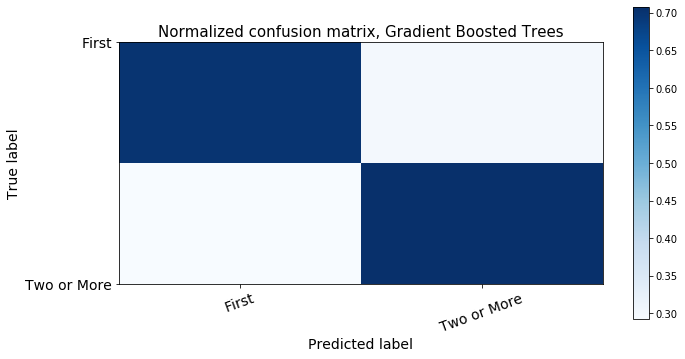

In [17]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [18]:
print(pd.DataFrame({'features': columns,
                    'importances': gbt_model.feature_importances_}).sort_values(['importances'], ascending = 0))


                          features  importances
52                division_Pacific     0.248781
3                           HERFLG     0.093954
53         division_South_Atlantic     0.083624
19                       age_group     0.075080
25                         psyprob     0.063049
..                             ...          ...
23                             vet     0.000000
34                      race_Asian     0.000000
32              race_Alaska_Native     0.000000
24                         arrests     0.000000
36  race_Hawaiian_Pacific_Islander     0.000000

[72 rows x 2 columns]


In [19]:
number_of_rows = x_train.shape[0]
random_indices = np.random.choice(number_of_rows, size=10000, replace=False)
random_data = x_train[random_indices,:]

In [20]:
f = lambda x: gbt_model.predict_proba(x)[:,1]
explainer = shap.Explainer(f, x_train, feature_names=columns)
shap_values = explainer(random_data)

Permutation explainer: 10001it [16:57,  9.83it/s]                            


In [21]:
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:65,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [22]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [23]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.71      0.71     48000


Normalized confusion matrix



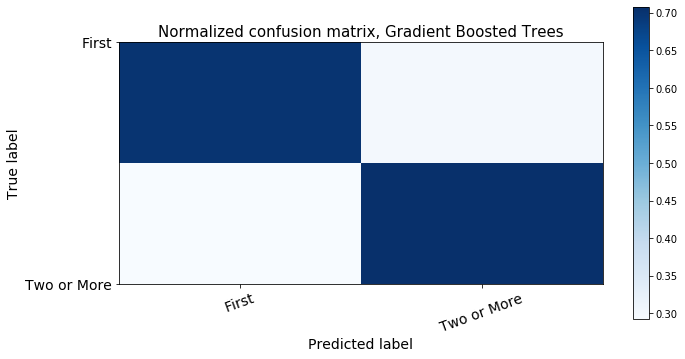

In [24]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [25]:
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:60,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [26]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [27]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.71      0.71     48000


Normalized confusion matrix



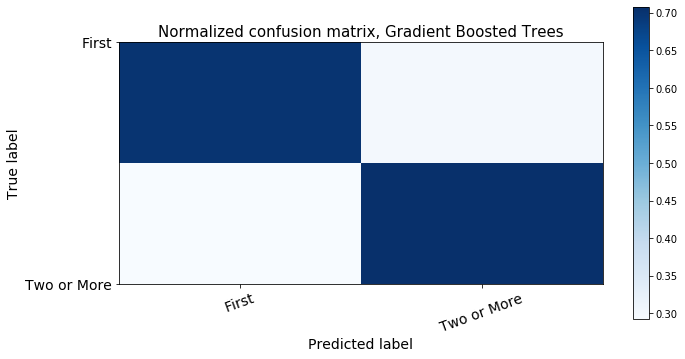

In [28]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [29]:
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:55,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [30]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [31]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.71      0.71     48000


Normalized confusion matrix



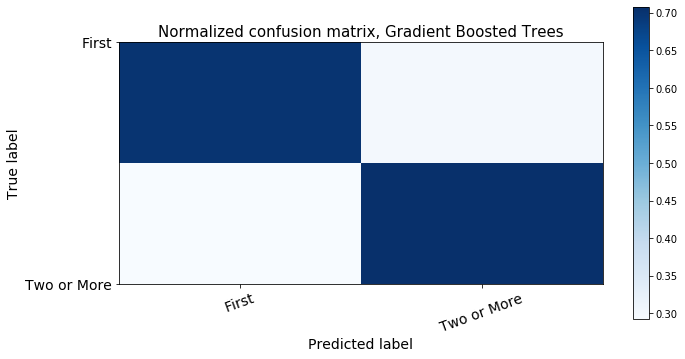

In [32]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [33]:
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:50,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [34]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [35]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.71      0.71     48000


Normalized confusion matrix



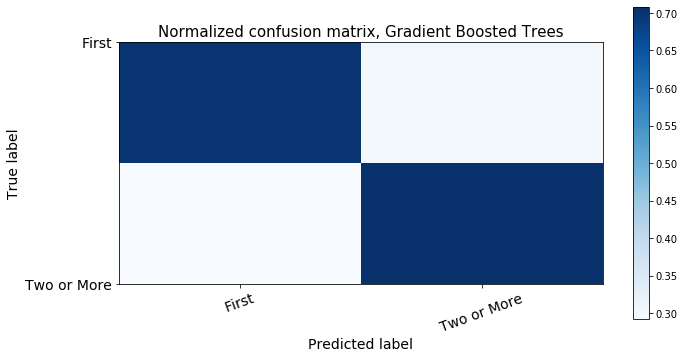

In [36]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [37]:
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:45,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [38]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [39]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.71      0.71     48000


Normalized confusion matrix



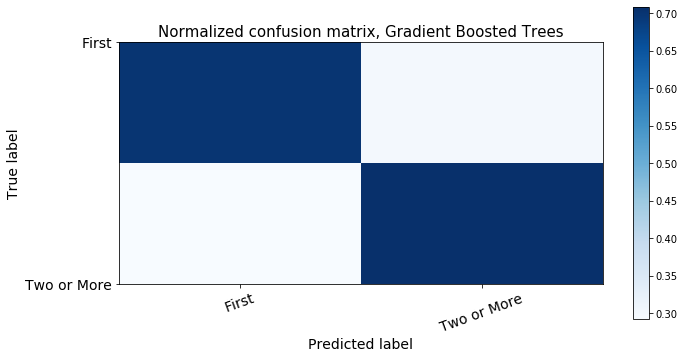

In [40]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [41]:
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:40,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [42]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [43]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.70      0.65     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.70     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.70      0.71     48000


Normalized confusion matrix



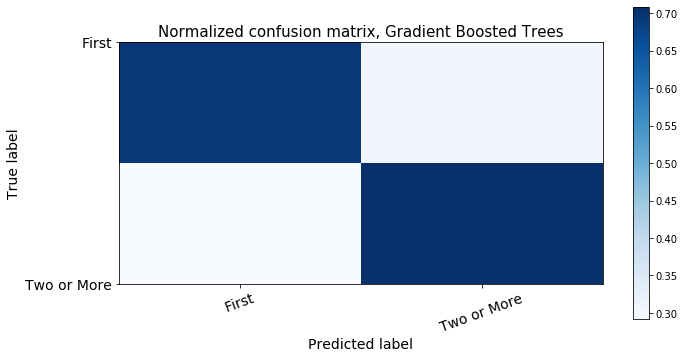

In [44]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [45]:
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:35,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [46]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [47]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.69      0.65     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.70     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.70      0.71     48000


Normalized confusion matrix



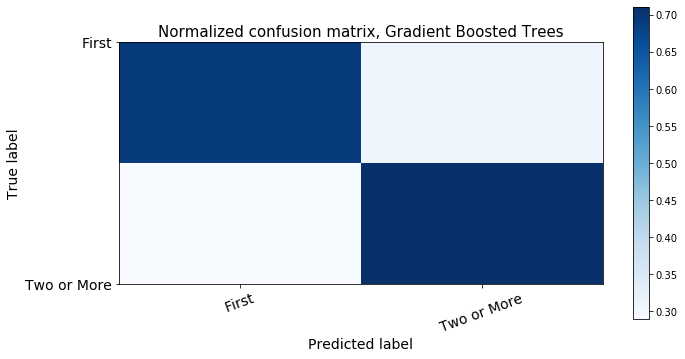

In [48]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [49]:
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:30,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [50]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [51]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.68      0.65     19253
           1       0.77      0.71      0.74     28747

    accuracy                           0.70     48000
   macro avg       0.69      0.70      0.70     48000
weighted avg       0.71      0.70      0.70     48000


Normalized confusion matrix



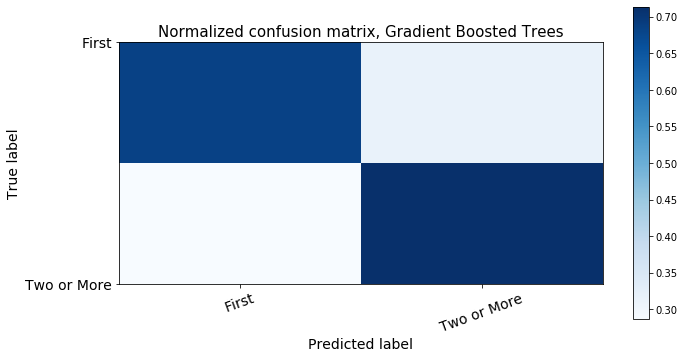

In [52]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [53]:
shap_sm

,feature,mean_shap_value,importance
0,age_group,-0.011288,0.011288
1,division_Pacific,-0.009822,0.009822
2,division_South_Atlantic,-0.008100,0.008100
71,division_East_South_Central,0.005796,0.005796
3,psyprob,-0.005421,0.005421
4,division_West_South_Central,-0.003920,0.003920
5,marstat_Never_Married,-0.003409,0.003409
70,frstuse,0.002783,0.002783
6,services_Ambulatory,-0.002694,0.002694
7,HERFLG,-0.002337,0.002337


In [54]:
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:25,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [55]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [56]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.61      0.68      0.65     19253
           1       0.77      0.71      0.74     28747

    accuracy                           0.70     48000
   macro avg       0.69      0.70      0.69     48000
weighted avg       0.71      0.70      0.70     48000


Normalized confusion matrix



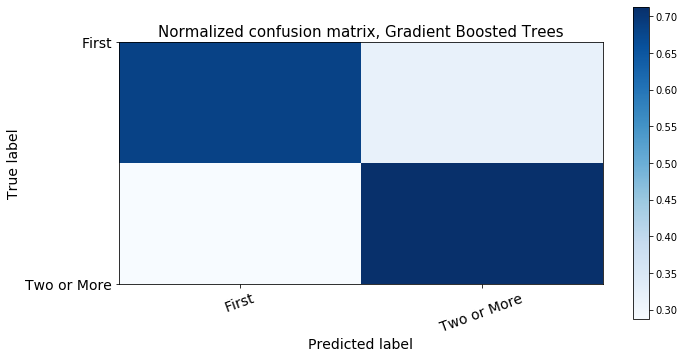

In [57]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

# 0       0.62      0.68      0.65     19253
# 1       0.77      0.72      0.75     28747

In [58]:
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:20,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [59]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [60]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.61      0.68      0.64     19253
           1       0.77      0.71      0.74     28747

    accuracy                           0.70     48000
   macro avg       0.69      0.70      0.69     48000
weighted avg       0.71      0.70      0.70     48000


Normalized confusion matrix



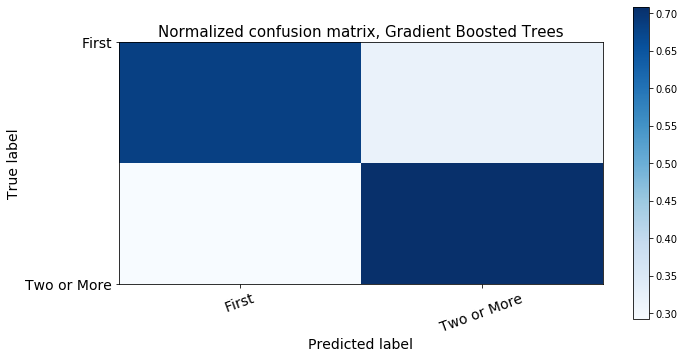

In [61]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [62]:
# FINAL FEATURES FOR SHAP
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:45,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

## Feature selection with tree-based feature importances

In [63]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model = GradientBoostingClassifier(random_state=75)
gbt_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model.predict_proba(x_validation)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.71      0.71     48000


Normalized confusion matrix



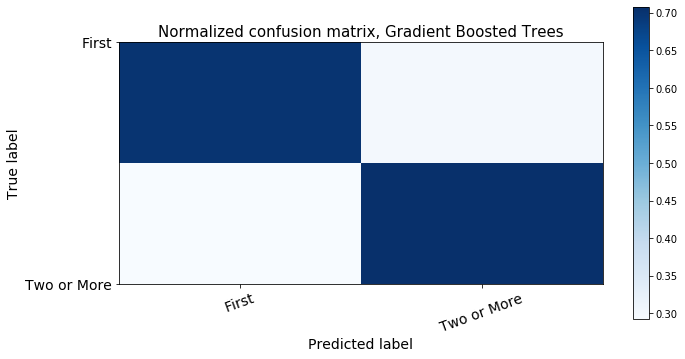

In [64]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [65]:
print(pd.DataFrame({'features': columns,
                    'importances': gbt_model.feature_importances_}).sort_values(['importances'], ascending = 0))

gbt_imp = pd.DataFrame({'features': columns, 'importances': gbt_model.feature_importances_})


                                  features  importances
52                        division_Pacific     0.248781
3                                   HERFLG     0.093954
53                 division_South_Atlantic     0.083624
19                               age_group     0.075080
25                                 psyprob     0.063049
58                     services_Ambulatory     0.058877
18                                 NUMSUBS     0.055542
56             division_West_South_Central     0.030200
51                    division_New_England     0.027811
40  psource_Alcohol_Drug_Care_Professional     0.026582
48             division_East_South_Central     0.026302
55             division_West_North_Central     0.022596
1                                  COKEFLG     0.022016
26                                 frstuse     0.019661
49                   division_Mid_Atlantic     0.018975
31                      injection_drug_use     0.018301
2                                   MARFLG     0

In [66]:
rf_model = RandomForestClassifier(random_state=75, n_estimators=100)
rf_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_rf = (rf_model.predict_proba(x_validation)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.69      0.65     19253
           1       0.78      0.72      0.74     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.71      0.71     48000


Normalized confusion matrix



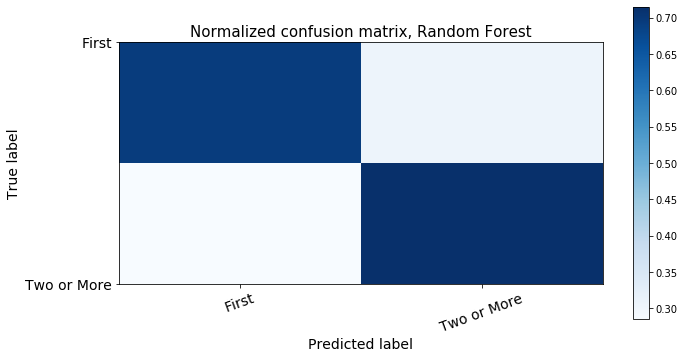

In [67]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_rf))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_validation, valid_predict_rf)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, 
                      normalize=True,title='Normalized confusion matrix, Random Forest')

In [68]:
# Print feature importances to subset data set to more important variables
print(pd.DataFrame({'features': columns,
                    'importances': rf_model.feature_importances_}).sort_values(['importances'], ascending = 0))

rf_imp = pd.DataFrame({'features': columns,
                    'importances': rf_model.feature_importances_}).sort_values(['importances'], ascending = 0)

                                  features  importances
19                               age_group     0.104511
26                                 frstuse     0.077353
22                                    educ     0.056980
27                                freq_use     0.042122
52                        division_Pacific     0.041786
20                                  gender     0.029522
18                                 NUMSUBS     0.027285
25                                 psyprob     0.025351
63                   marstat_Never_Married     0.020535
3                                   HERFLG     0.019877
39                              race_White     0.019272
46                   psource_Self_referral     0.019224
71              livarag_Independent_Living     0.019190
68                       employ_Unemployed     0.018810
66               employ_Not_in_labor_force     0.017741
42                  psource_Court_Referral     0.016874
53                 division_South_Atlantic     0

In [69]:
importances = pd.concat([rf_imp,gbt_imp]).groupby('features').median().reset_index().sort_values('importances',ascending=False)
features_subset_index = importances.iloc[0:65,:].index

In [70]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [71]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

gbt_imp = pd.DataFrame({'features': features_sm,
                    'importances': gbt_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0)

              precision    recall  f1-score   support

           0       0.61      0.70      0.65     19253
           1       0.78      0.70      0.74     28747

    accuracy                           0.70     48000
   macro avg       0.69      0.70      0.69     48000
weighted avg       0.71      0.70      0.70     48000


Normalized confusion matrix



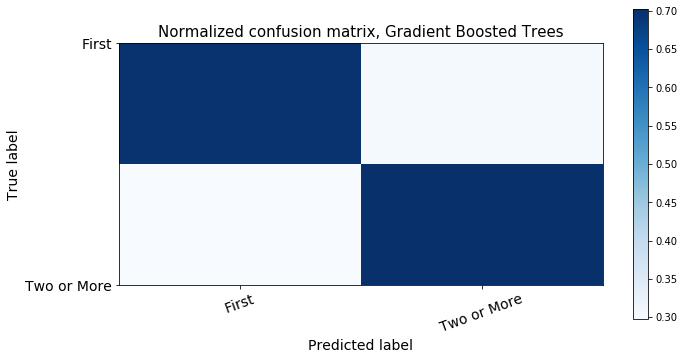

In [72]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [73]:
rf_model_sm = RandomForestClassifier(random_state=75, n_estimators=100)
rf_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_rf = (rf_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

rf_imp = pd.DataFrame({'features': features_sm,
                    'importances': rf_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0)

              precision    recall  f1-score   support

           0       0.62      0.70      0.65     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.70     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.70      0.71     48000


Normalized confusion matrix



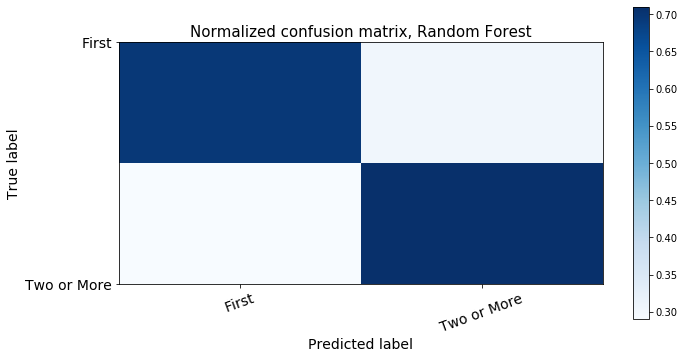

In [74]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_rf))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_validation, valid_predict_rf)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [75]:
importances = pd.concat([rf_imp,gbt_imp]).groupby('features').median().reset_index().sort_values('importances',ascending=False)
features_subset_index = importances.iloc[0:60,:].index

In [76]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [77]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

gbt_imp = pd.DataFrame({'features': features_sm,
                    'importances': gbt_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0)

              precision    recall  f1-score   support

           0       0.61      0.69      0.65     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.70     48000
   macro avg       0.69      0.70      0.70     48000
weighted avg       0.71      0.70      0.70     48000


Normalized confusion matrix



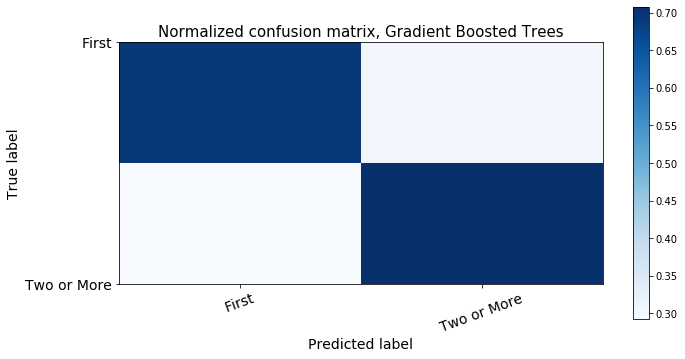

In [78]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [79]:
rf_model_sm = RandomForestClassifier(random_state=75, n_estimators=100)
rf_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_rf = (rf_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

rf_imp = pd.DataFrame({'features': features_sm,
                    'importances': rf_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0)

              precision    recall  f1-score   support

           0       0.61      0.68      0.64     19253
           1       0.77      0.71      0.74     28747

    accuracy                           0.70     48000
   macro avg       0.69      0.69      0.69     48000
weighted avg       0.70      0.70      0.70     48000


Normalized confusion matrix



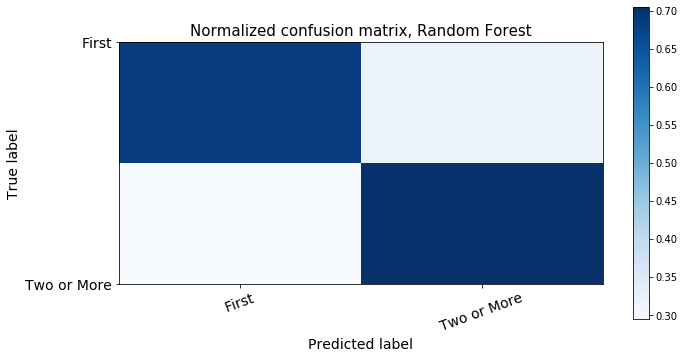

In [80]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_rf))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_validation, valid_predict_rf)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [81]:
importances = pd.concat([rf_imp,gbt_imp]).groupby('features').median().reset_index().sort_values('importances',ascending=False)
features_subset_index = importances.iloc[0:55,:].index

In [82]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [83]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

gbt_imp = pd.DataFrame({'features': features_sm,
                    'importances': gbt_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0)

              precision    recall  f1-score   support

           0       0.61      0.69      0.65     19253
           1       0.77      0.71      0.74     28747

    accuracy                           0.70     48000
   macro avg       0.69      0.70      0.69     48000
weighted avg       0.71      0.70      0.70     48000


Normalized confusion matrix



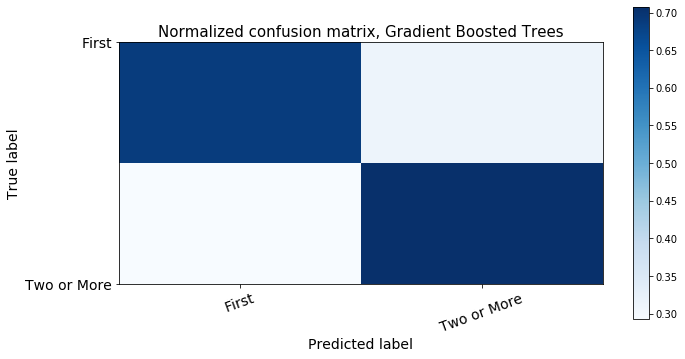

In [84]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [85]:
rf_model_sm = RandomForestClassifier(random_state=75, n_estimators=100)
rf_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_rf = (rf_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

rf_imp = pd.DataFrame({'features': features_sm,
                    'importances': rf_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0)

              precision    recall  f1-score   support

           0       0.60      0.67      0.63     19253
           1       0.76      0.70      0.73     28747

    accuracy                           0.69     48000
   macro avg       0.68      0.69      0.68     48000
weighted avg       0.70      0.69      0.69     48000


Normalized confusion matrix



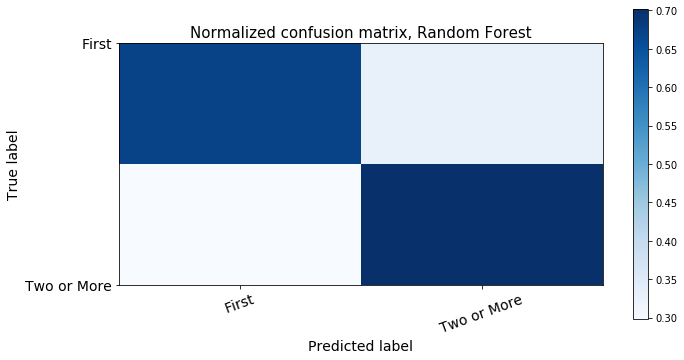

In [86]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_rf))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_validation, valid_predict_rf)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [87]:
importances = pd.concat([rf_imp,gbt_imp]).groupby('features').median().reset_index().sort_values('importances',ascending=False)
features_subset_index = importances.iloc[0:50,:].index

In [88]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [89]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

gbt_imp = pd.DataFrame({'features': features_sm,
                    'importances': gbt_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0)

              precision    recall  f1-score   support

           0       0.60      0.67      0.63     19253
           1       0.76      0.71      0.73     28747

    accuracy                           0.69     48000
   macro avg       0.68      0.69      0.68     48000
weighted avg       0.70      0.69      0.69     48000


Normalized confusion matrix



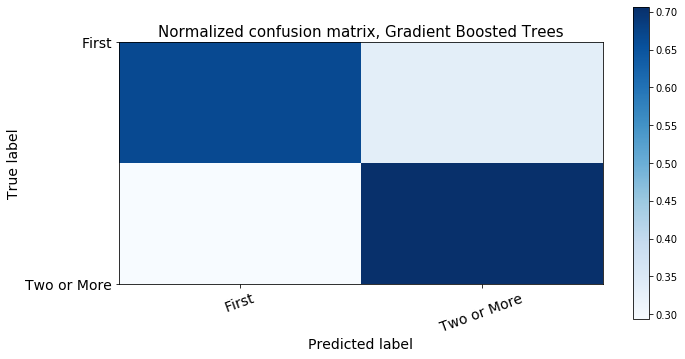

In [90]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [91]:
rf_model_sm = RandomForestClassifier(random_state=75, n_estimators=100)
rf_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_rf = (rf_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

rf_imp = pd.DataFrame({'features': features_sm,
                    'importances': rf_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0)

              precision    recall  f1-score   support

           0       0.59      0.66      0.62     19253
           1       0.75      0.69      0.72     28747

    accuracy                           0.68     48000
   macro avg       0.67      0.67      0.67     48000
weighted avg       0.69      0.68      0.68     48000


Normalized confusion matrix



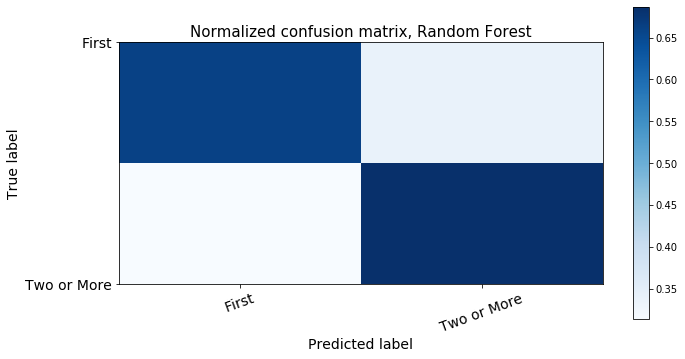

In [92]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_rf))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_validation, valid_predict_rf)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [93]:
importances = pd.concat([rf_imp,gbt_imp]).groupby('features').median().reset_index().sort_values('importances',ascending=False)
features_subset_index = importances.iloc[0:45,:].index

In [94]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index]

In [95]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

gbt_imp = pd.DataFrame({'features': features_sm,
                    'importances': gbt_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0)

              precision    recall  f1-score   support

           0       0.54      0.70      0.61     19253
           1       0.75      0.61      0.67     28747

    accuracy                           0.64     48000
   macro avg       0.65      0.65      0.64     48000
weighted avg       0.67      0.64      0.65     48000


Normalized confusion matrix



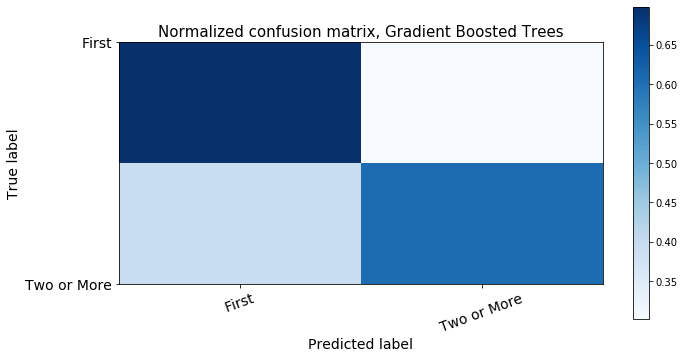

In [96]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [97]:
rf_model_sm = RandomForestClassifier(random_state=75, n_estimators=100)
rf_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_rf = (rf_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

rf_imp = pd.DataFrame({'features': features_sm,
                    'importances': rf_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0)

              precision    recall  f1-score   support

           0       0.54      0.63      0.58     19253
           1       0.72      0.64      0.68     28747

    accuracy                           0.64     48000
   macro avg       0.63      0.64      0.63     48000
weighted avg       0.65      0.64      0.64     48000


Normalized confusion matrix



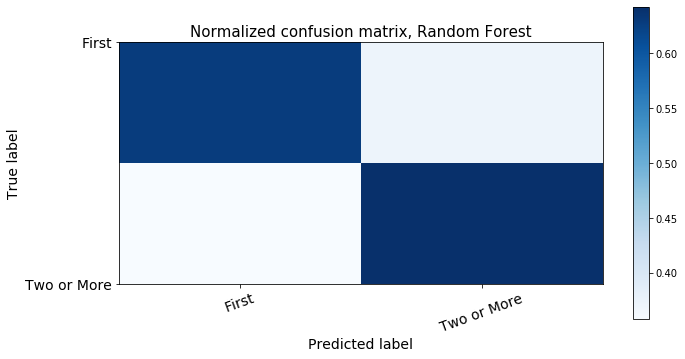

In [98]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_rf))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_validation, valid_predict_rf)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [99]:
### Final feature importance model
importances = pd.concat([rf_imp,gbt_imp]).groupby('features').median().reset_index().sort_values('importances',ascending=False)
features_subset_index = importances.iloc[0:55,:].index

## SHAP Demo

In [100]:
# FINAL FEATURES FOR SHAP
pd.set_option("display.max_rows", 100, "display.max_columns", 50)

shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.columns = columns

shap_means = pd.DataFrame(shap_values_df.mean().sort_values()).reset_index()
shap_means.columns = ['feature','mean_shap_value']
shap_means['importance'] = abs(shap_means['mean_shap_value'])
shap_means = shap_means.sort_values('importance',ascending=False)
shap_means.shape
shap_sm = shap_means.iloc[0:45,:]
features_subset = list(shap_sm['feature'])
features_subset_index = [data.columns.get_loc(col) for col in features_subset]

In [101]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, features_subset_index]
x_validation_sm = x_validation[:, features_subset_index]
x_test_sm = x_test[:, features_subset_index]
features_sm = data.iloc[:, features_subset_index].columns

In [102]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt = (gbt_model_sm.predict_proba(x_validation_sm)[:,1]>=0.6).astype(int)

              precision    recall  f1-score   support

           0       0.62      0.70      0.66     19253
           1       0.78      0.71      0.74     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.70      0.70     48000
weighted avg       0.71      0.71      0.71     48000


Normalized confusion matrix



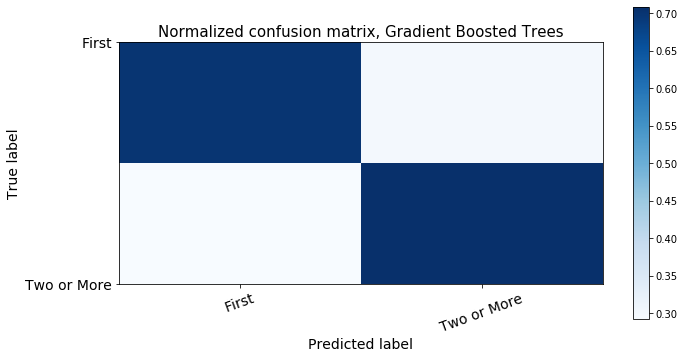

In [103]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [104]:
number_of_rows = x_train_sm.shape[0]
random_indices = np.random.choice(number_of_rows, size=10000, replace=False)
random_data = x_train_sm[random_indices,:]

In [105]:
f = lambda x: gbt_model_sm.predict_proba(x)[:,1]
explainer = shap.Explainer(f, x_train_sm, feature_names=features_sm)
shap_values = explainer(random_data)

Permutation explainer: 10001it [09:20, 17.83it/s]                           


In [120]:
shap_values

.values =
array([[ 3.08e-02,  1.22e-02,  1.60e-02, ...,  6.80e-03, -6.20e-03,
         6.73e-04],
       [-8.41e-03,  1.52e-02,  1.59e-02, ..., -1.55e-04, -2.03e-03,
         5.47e-06],
       [ 8.07e-03,  1.40e-02,  1.71e-02, ..., -7.97e-04,  7.64e-02,
         3.28e-05],
       ...,
       [ 1.25e-02,  1.27e-02,  1.46e-02, ..., -1.23e-03, -4.63e-03,
        -1.40e-05],
       [ 8.21e-03,  1.46e-02,  1.53e-02, ..., -2.07e-04,  6.03e-02,
         6.35e-05],
       [-2.83e-02,  1.34e-02,  1.94e-02, ..., -5.78e-04, -6.27e-03,
         2.31e-05]])

.base_values =
array([0.65, 0.65, 0.65, ..., 0.65, 0.65, 0.65])

.data =
array([[10.,  0.,  0., ...,  1.,  0.,  1.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 6.,  0.,  0., ...,  0.,  1.,  0.],
       ...,
       [ 7.,  0.,  0., ...,  0.,  0.,  0.],
       [ 6.,  0.,  0., ...,  0.,  1.,  1.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.]])

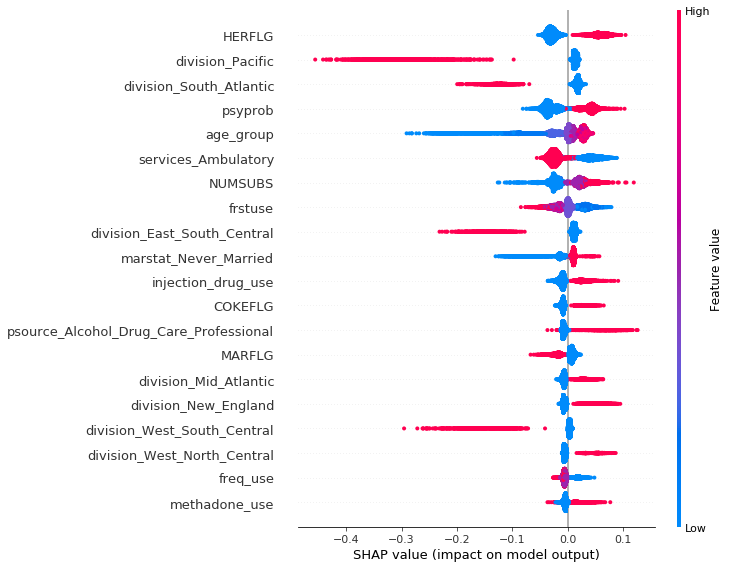

In [106]:
shap.summary_plot(shap_values, feature_names=features_sm)

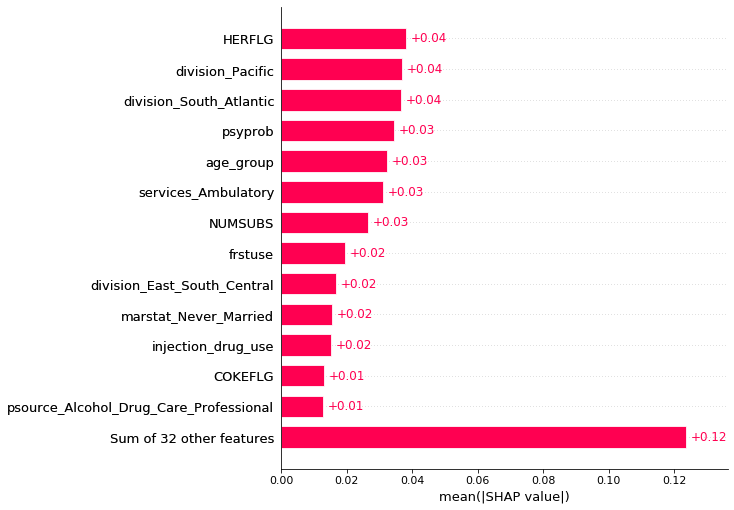

In [107]:
shap.plots.bar(shap_values, max_display=14)

In [119]:
shap.initjs()
shap.plots.force(base_value=shap_values.base_values[0], shap_values=shap_values.values[0], features=x_train_sm[0], feature_names=features_sm)

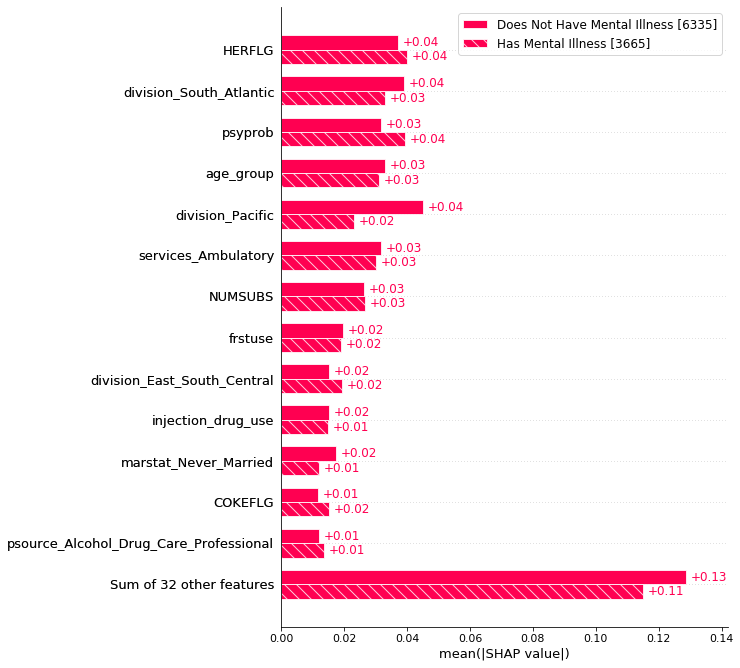

In [115]:
mntlill = ["Has Mental Illness" if shap_values[i,"psyprob"].data == 1 else "Does Not Have Mental Illness" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(mntlill).abs.mean(0),max_display=14)

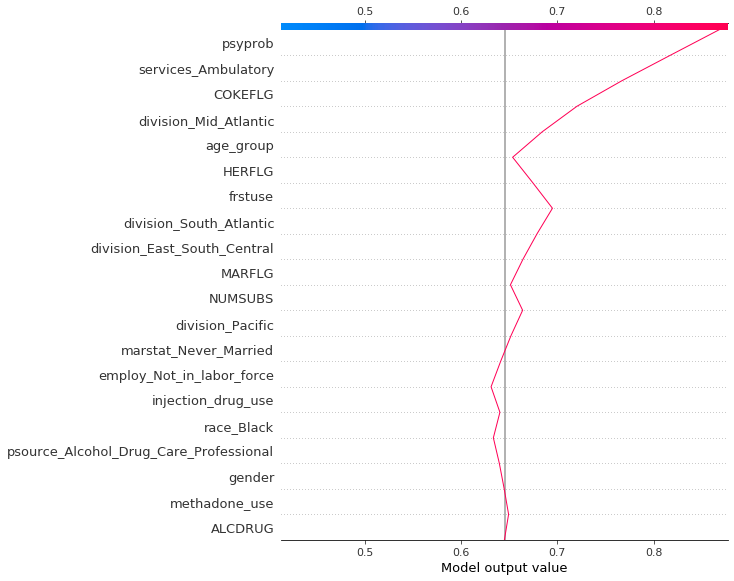

In [116]:
ind = random_indices[0]
shap.decision_plot(base_value=shap_values.base_values[0], shap_values=shap_values.values[0], feature_names=list(features_sm))

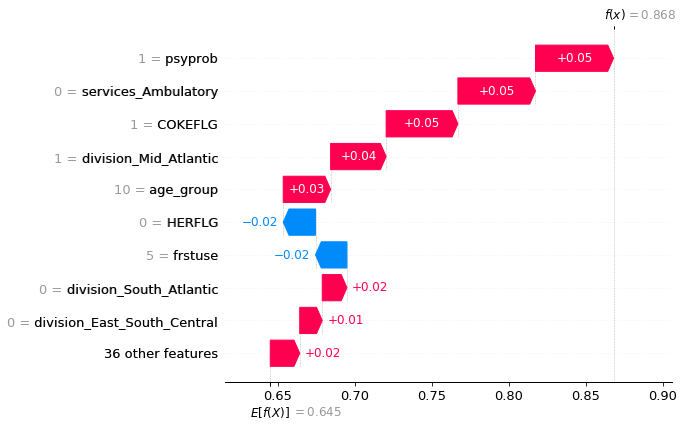

In [117]:
shap.plots.waterfall(shap_values[0])